In [2]:
import re
import pickle
from pykakasi import kakasi
import pickle
import numpy as np
from keras.models import Model
from keras.layers import Dense, GRU, Input, Masking
from keras.callbacks import EarlyStopping 
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import load_model

# 同じ階層に"bot.txt"を準備
with open("bot.txt", mode="r", encoding="utf-8") as f:  # ファイルの読み込み
    bot_original = f.read()


bot = re.sub("[\n]", "。", bot_original) # | と全角半角スペース、「」と改行の削除
bot = re.sub("[｜ 　]", "", bot) # | と全角半角スペース、「」と改行の削除

bot = bot.replace('！。', '！')
bot = bot.replace('？。', '？')
bot = bot.replace('♪。', '♪')
bot = bot.replace('？*', '？')
bot = bot.replace('♪？', '♪')
bot = bot.replace('。*', '。')

print("文字数:", len(bot))

文字数: 280405


In [3]:
seperator = "。"  # 。をセパレータに指定
bot_list = re.split('[。！？♪]', bot)  # セパレーターを使って文章をリストに分割する
bot_list.pop() # 最後の要素は空の文字列になるので、削除
bot_list.pop(0)
bot_list = [x+seperator for x in bot_list]  # 文章の最後に。を追加

kakasi = kakasi()
kakasi.setMode("J", "H")  # J(漢字) からH(ひらがな)へ
conv = kakasi.getConverter()

In [4]:
kana_text = conv.do(bot)  # 全体をひらがなに変換
print(set(kana_text))  # set()で文字の重複をなくす

{'x', 'け', 'す', '+', 'ギ', 'z', 'ニ', 'セ', 'ベ', 'げ', 'A', 'カ', 'ぞ', '2', '。', 'r', 'ど', 'ぁ', 'ゲ', 'ー', 'い', 'み', '3', 'm', '・', 'メ', 'J', 'G', 'ぢ', 'V', '\t', 'ぎ', 'ダ', '！', 'わ', 'ウ', 'W', '.', 'ワ', 'ポ', 'も', 'H', 'ャ', 'Z', 'E', 'ぺ', 'グ', '4', 'ひ', 'ユ', '6', 'ブ', 'ケ', '5', 'B', 'め', 's', 'ナ', 'パ', 'し', 'コ', 'ヘ', 'u', 'な', 'ゴ', 'ふ', 'ご', 'や', '&', 'ぷ', '、', 'リ', 'キ', 'ツ', 'I', '♪', 'サ', 'i', 'T', 'せ', 'び', ':', 't', 'エ', '!', 'に', 'ゅ', 'ロ', 'ゃ', '0', 'f', 'さ', 'ず', 'ズ', 'あ', 'テ', 'ぬ', 'O', 'ん', 'ビ', 'w', '%', 'ゥ', 'ド', 'Q', 'ペ', 'ほ', 'ミ', 'ょ', 'g', 'だ', '-', 'X', 'つ', 'F', 'ボ', 'ク', 'ヨ', 'b', 'っ', 'ハ', 'ョ', 'デ', 'ァ', 'タ', 'ィ', 'ヒ', '\ufeff', '〜', 'ン', 'く', 'h', 'ノ', 'y', 'ム', 'L', 'ェ', ',', '）', 'Ｄ', '‥', 'M', 'る', 'ガ', 'ヴ', 'ぅ', 'ぴ', 'ぽ', 'Y', 'ヵ', 'ね', 'n', 'そ', 'バ', 'ぜ', 'ぼ', 'l', 'モ', 'ち', 'S', 'ま', 'ホ', 'べ', 'マ', 'ネ', 'ぶ', 'づ', 'ュ', 'ヌ', 'ゾ', 'よ', 'ジ', '②', 'ォ', 'ソ', 'ト', 'は', '1', '9', 'P', 'Ｃ', 'れ', 'む', 'e', 'ゆ', 'ス', 'ピ', 'と', 'ぱ', 'こ', 'ざ', 'ぐ', 'a', 'ぃ', '，', 'て', 'q', 'シ', 'R'

In [5]:
with open("kana_bot.txt", mode="w", encoding="utf-8") as f:
    f.write(kana_text)

In [7]:
hiragana = "ぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞ\
ただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽ\
まみむめもゃやゅゆょよらりるれろゎわゐゑをん"

katakana = "ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾ\
タダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポ\
マミムメモャヤュユョヨラリルレロヮワヰヱヲンヴ"

chars = hiragana + katakana

with open("kana_bot.txt", mode="r", encoding="utf-8") as f:  # 前回保存したファイル
    text = f.read()
    
for char in text:  # ひらがな、カタカナ以外でコーパスに使われている文字を追加
    if char not in chars:
        chars += char
        
chars += "\t\n"  # タブと改行を追加
        
chars_list = sorted(list(chars))  # 文字列をリストに変換してソートする
print(chars_list)

with open("kana_chars.pickle", mode="wb") as f:  # pickleで保存
    pickle.dump(chars_list, f)

['\t', '\t', '\n', '!', '%', '&', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '9', ':', 'A', 'B', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '‥', '…', '②', '♪', '、', '。', '〜', 'ぁ', 'あ', 'ぃ', 'い', 'ぅ', 'う', 'ぇ', 'え', 'ぉ', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'っ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ぱ', 'ひ', 'び', 'ぴ', 'ふ', 'ぶ', 'ぷ', 'へ', 'べ', 'ぺ', 'ほ', 'ぼ', 'ぽ', 'ま', 'み', 'む', 'め', 'も', 'ゃ', 'や', 'ゅ', 'ゆ', 'ょ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'ゎ', 'わ', 'ゐ', 'ゑ', 'を', 'ん', 'ァ', 'ア', 'ィ', 'イ', 'ゥ', 'ウ', 'ェ', 'エ', 'ォ', 'オ', 'カ', 'ガ', 'キ', 'ギ', 'ク', 'グ', 'ケ', 'ゲ', 'コ', 'ゴ', 'サ', 'ザ', 'シ', 'ジ', 'ス', 'ズ', 'セ', 'ゼ', 'ソ', 'ゾ', 'タ', 'ダ', 'チ', 'ヂ', 'ッ', 'ツ', 'ヅ', 'テ', 'デ', 'ト', 'ド', 'ナ', 'ニ', 'ヌ', '

In [8]:
# インデックスと文字で辞書を作成
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars_list):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars_list):
    indices_char[i] = char
    
seperator = "。"

sentence_list = re.split('[。！？♪]', text)  # セパレーターを使って文章をリストに分割する
sentence_list.pop() 
sentence_list = [x+seperator for x in sentence_list]

max_sentence_length = 128  # 文章の最大長さ。これより長い文章はカットされる。
sentence_list = [sentence for sentence in sentence_list if len(sentence) <= max_sentence_length]  # 長すぎる文章のカット

n_char = len(chars_list)  # 文字の種類の数
n_sample = len(sentence_list) - 1  # サンプル数

x_sentences = []  # 入力の文章
t_sentences = []  # 正解の文章
for i in range(n_sample):
    x_sentences.append(sentence_list[i])
    t_sentences.append("\t" + sentence_list[i+1] + "\n")  # 正解は先頭にタブ、末尾に改行を加える
max_length_x = max_sentence_length  # 入力文章の最大長さ
max_length_t = max_sentence_length + 2  # 正解文章の最大長さ

x_encoder = np.zeros((n_sample, max_length_x, n_char), dtype=np.bool)  # encoderへの入力
x_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)  # decoderへの入力
t_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)  # decoderの正解

for i in range(n_sample):
    x_sentence = x_sentences[i]
    t_sentence = t_sentences[i]
    for j, char in enumerate(x_sentence):
        x_encoder[i, j, char_indices[char]] = 1  # encoderへの入力をone-hot表現で表す
    for j, char in enumerate(t_sentence):
        x_decoder[i, j, char_indices[char]] = 1  # decoderへの入力をone-hot表現で表す
        if j > 0:  # 正解は入力より1つ前の時刻のものにする
            t_decoder[i, j-1, char_indices[char]] = 1
            
print(x_encoder.shape)

(19047, 128, 252)


In [9]:
batch_size = 64
epochs = 150
n_mid = 128  # 中間層のニューロン数

In [10]:
encoder_input = Input(shape=(None, n_char))
encoder_mask = Masking(mask_value=0)  # 全ての要素が0であるベクトルの入力は無視する
encoder_masked = encoder_mask(encoder_input)
encoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_state=True)  # dropoutを設定し、ニューロンをランダムに無効にする
encoder_output, encoder_state_h = encoder_lstm(encoder_masked)

decoder_input = Input(shape=(None, n_char))
decoder_mask = Masking(mask_value=0)  # 全ての要素が0であるベクトルの入力は無視する
decoder_masked = decoder_mask(decoder_input)
decoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True)  # dropoutを設定
decoder_output, _ = decoder_lstm(decoder_masked, initial_state=encoder_state_h)  # encoderの状態を初期状態にする
decoder_dense = Dense(n_char, activation='softmax')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
print(model.summary())

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 252)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 252)    0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 252)    0           input_1[0][0]                    
__________________________________________________________________________________________________
masking_2 (Masking)             (None, None, 252)    0           input_2[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU

In [11]:
# val_lossに改善が見られなくなってから、10エポックで学習は終了
early_stopping = EarlyStopping(monitor="val_loss", patience=10) 

history = model.fit([x_encoder, x_decoder], t_decoder,
                     batch_size=64,
                     epochs=150,
                     validation_split=0.1,  # 10%は検証用
                     callbacks=[early_stopping])

Train on 17142 samples, validate on 1905 samples
Epoch 1/150
17142/17142 [==============================] - 161s 9ms/step - loss: 3.5518 - val_loss: 3.0041
Epoch 2/150
17142/17142 [==============================] - 148s 9ms/step - loss: 3.0277 - val_loss: 2.7362
Epoch 3/150
17142/17142 [==============================] - 148s 9ms/step - loss: 2.8685 - val_loss: 2.6393
Epoch 4/150
17142/17142 [==============================] - 143s 8ms/step - loss: 2.7871 - val_loss: 2.5764
Epoch 5/150
17142/17142 [==============================] - 142s 8ms/step - loss: 2.7305 - val_loss: 2.5217
Epoch 6/150
17142/17142 [==============================] - 142s 8ms/step - loss: 2.6836 - val_loss: 2.4857
Epoch 7/150
17142/17142 [==============================] - 143s 8ms/step - loss: 2.6471 - val_loss: 2.4502
Epoch 8/150
17142/17142 [==============================] - 142s 8ms/step - loss: 2.6155 - val_loss: 2.4314
Epoch 9/150
17142/17142 [==============================] - 142s 8ms/step - loss: 2.5854 - val_l

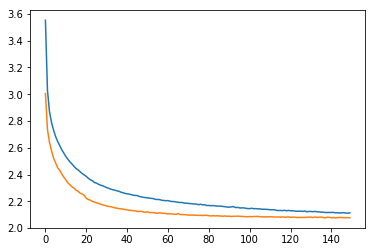

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.show()

In [13]:
# encoderのモデル
encoder_model = Model(encoder_input, encoder_state_h)

# decoderのモデル
decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h]

decoder_output, decoder_state_h = decoder_lstm(decoder_input,
                                               initial_state=decoder_state_in_h)
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_in,
                      [decoder_output, decoder_state_h])

# モデルの保存
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [14]:
def respond(input_data, beta=5):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, n_char))  # decoderの出力を格納する配列
    y_decoder[0][0][char_indices["\t"]] = 1  # decoderの最初の入力はタブ。one-hot表現にする。

    respond_sentence = ""  # 返答の文字列
    while True:
        y, h = decoder_model.predict([y_decoder, state_value])
        p_power = y[0][0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power)) 
        next_char = indices_char[next_index]  # 次の文字

        if (next_char == "\n" or len(respond_sentence) >= max_length_x):
            break  # 次の文字が改行のとき、もしくは最大文字数を超えたときは終了
            
        respond_sentence += next_char
        y_decoder = np.zeros((1, 1, n_char))  # 次の時刻の入力
        y_decoder[0][0][next_index] = 1

        state_value = h  # 次の時刻の状態

    return respond_sentence

In [15]:
# インデックスと文字で辞書を作成
char_indices = {}
for i, char in enumerate(chars_list):
    char_indices[char] = i
indices_char = {}
for i, char in enumerate(chars_list):
    indices_char[i] = char
    
n_char = len(chars_list)
max_length_x = 128

# 文章をone-hot表現に変換する関数
def sentence_to_vector(sentence):
    vector = np.zeros((1, max_length_x, n_char), dtype=np.bool)
    for j, char in enumerate(sentence):
        vector[0][j][char_indices[char]] = 1
    return vector

In [16]:
encoder_model = load_model('encoder_model.h5')
decoder_model = load_model('decoder_model.h5')

def respond(input_data, beta=2):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, n_char))  # decoderの出力を格納する配列
    y_decoder[0][0][char_indices['\t']] = 1  # decoderの最初の入力はタブ。one-hot表現にする。

    respond_sentence = ""  # 返答の文字列
    while True:
        y, h = decoder_model.predict([y_decoder, state_value])
        p_power = y[0][0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power)) 
        next_char = indices_char[next_index]  # 次の文字
        
        if (next_char == "\n" or len(respond_sentence) >= max_length_x):
            break  # 次の文字が改行のとき、もしくは最大文字数を超えたときは終了
            
        respond_sentence += next_char
        y_decoder = np.zeros((1, 1, n_char))  # 次の時刻の入力
        y_decoder[0][0][next_index] = 1

        state_value = h  # 次の時刻の状態

    return respond_sentence

C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [17]:
response_a = "こんにちは。"
response_b = ""
for i in range(10):
    print("A君:", response_a)
    print()  
    vector_a = sentence_to_vector(response_a)
    
    response_b = respond(vector_a)
    print("B君:", response_b)
    print()
    vector_b = sentence_to_vector(response_b)
    
    response_a = respond(vector_b)

A君: こんにちは。

B君: こんにちはあなたがないばい。

A君: あなたがきょうどうばい。

B君: またあなたがすごいばい。

A君: あなたのきょうのかんかえるばい。

B君: そうばいね。

A君: いいよね。

B君: あなたはそれならかえったらだいじょうぶだとおもう。

A君: いまからでんしゃできた。

B君: ドレスきていこう。

A君: つかれてるね。

B君: おつかれさま。

A君: あしたもおわった。

B君: うん。

A君: かいしゃはいいね。

B君: おはよう。

A君: あなたもおんせんしてるからあなたがよくねる。

B君: そうだね。

A君: いまからがんばる。

B君: あなたがいさんときにいく。

